# App-ifying 'recovering data from images'

**See [the other notebook](Guessing_colourmaps.ipynb) for the grisly details and dead-ends.** 

Requirements:

- `numpy`
- `scipy`
- `scikit-learn`
- `pillow`

I recommend installing them with `conda install`. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Make an image

Make some fake data and apply a colourmap.

In [2]:
from scipy import signal

In [3]:
nx, ny = 100, 100
z = np.random.rand(nx, ny)

sizex, sizey = 30, 30
x, y = np.mgrid[-sizex:sizex+1, -sizey:sizey+1]
g = np.exp(-0.333*(x**2/float(sizex)+y**2/float(sizey)))
f = g/g.sum()

z = signal.convolve(z, f, mode='valid')
z = (z - z.min())/(z.max() - z.min())

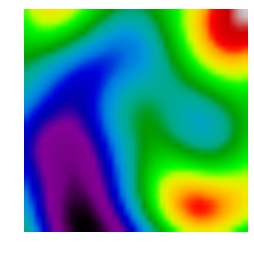

In [4]:
# Note: interpolation introduces new colours.
plt.imshow(z, cmap="spectral")
#plt.imshow(z, cmap="spectral", interpolation='none')

plt.axis('off')
plt.savefig('data/cbar/test.png', bbox_inches='tight')
plt.show()

## Read an image

In [247]:
cd /Users/matt/Dropbox/dev/notebooks

/Users/matt/Dropbox/dev/notebooks


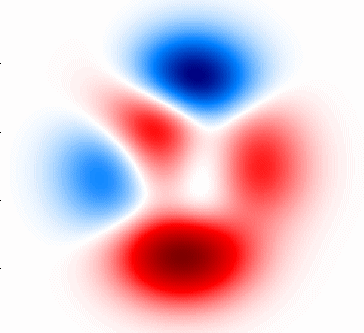

In [248]:
from PIL import Image

# img = Image.open('data/cbar/boxer.png')
# img = Image.open('data/cbar/fluid.png')
# img = Image.open('data/cbar/lisa.png')
img = Image.open('data/cbar/redblu.png')
# img = Image.open('data/cbar/seismic.png')
# img = Image.open('data/cbar/drainage.jpg')
# img = Image.open('data/cbar/test.png')

img

In [249]:
img.size

(364, 333)

Instead of taking a random sample, let's take all pixels from a smaller version of the image.

In [250]:
def resize_if_necessary(img, max_size=256):
    h, w = img.size
    if h * w > max_size**2:
        img = img.resize((max_size, max_size))
    return img

In [251]:
img_sm = resize_if_necessary(img)

Cast as an array, and ignore the last channel (alpha), if there is one.

## Quantize with scikit

In [252]:
from sklearn.cluster import KMeans
from sklearn.utils import shuffle

In [253]:
im = np.asarray(img) / 255
h, w, d = im.shape
im_ = im.reshape((w * h, d))[:, :3]
sample = shuffle(im_, random_state=0)[:1000]  # Defines training set size

In [254]:
im.dtype, im.shape, im_.shape

(dtype('float64'), (333, 364, 4), (121212, 3))

In [255]:
kmeans = KMeans(n_clusters=256, random_state=0).fit(sample)

Now I can make and regularize an RGB palette `p`:

In [256]:
p = kmeans.cluster_centers_[:, :3]

# Make certain we're in [0, 1]
p[p<1e-9] = 0
p[p>1] = 1

In [257]:
labels = kmeans.predict(im_)

In [258]:
def recreate_image(palette, labels, h, w):
    image = np.zeros((h, w, palette.shape[1]))
    label_idx = 0
    for i in range(h):
        for j in range(w):
            image[i][j] = palette[labels[label_idx]]
            label_idx += 1
    return image

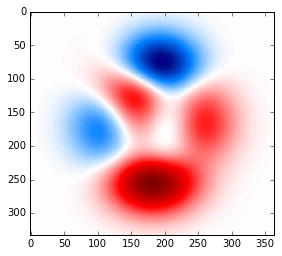

In [259]:
q = recreate_image(p, labels, h, w)

plt.imshow(q)
plt.show()

## Travelling salesman problem

Remember that these points are essentially in random order, and that there are many, many duplicates. Most of those dots are actually hundreds of dots.

We would like to measure ditances between dots. This is just a norm, but there's a convenient function in `scipy.spatial` for finding distances in *n*-space, `pdist`. then `squareform` makes it into a square, symmetric matrix, which is what we need.

Two main algos:

* LKH http://www.akira.ruc.dk/~keld/research/LKH/
* Concorde http://www.math.uwaterloo.ca/tsp/concorde.html
* OR Tools from Google https://developers.google.com/optimization/routing/tsp

* I followed these instructions for installing concorde on my Mac: http://davidsjohnson.net/TSPcourse/mac-install-concorde.txt

I think I've installed Concorde, LKH and OR Tools.

LKH and Concorde can be used via this Python package: https://github.com/perrygeo/pytsp (but note that it used to be called `pyconcorde` so you need to change the names of some functions — look at the source. I can't get the `concorde` implementation to work... see error below. 

Compile the libs and add to PATH as mentioned in the docs for `pytsp`. 

In [260]:
from pytsp import run, dumps_matrix

Add black and white to `p`:

In [261]:
p = np.vstack([[[0,0,0]], p])

In [262]:
p[:5]

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.99607843,  0.99215686,  0.99215686],
       [ 1.        ,  0.38823529,  0.38823529],
       [ 0.        ,  0.45098039,  0.94901961],
       [ 0.82745098,  0.        ,  0.        ]])

In [263]:
from scipy.spatial.distance import pdist, squareform

# Make distacnce matrix.
dists = squareform(pdist(p))

d = dists * 10000
d = d.astype(int)

In [264]:
outf = "/tmp/myroute_concorde.tsp"
with open(outf, 'w') as f:
    f.write(dumps_matrix(d, name="My Route"))

In [265]:
tour_concorde = run(outf, start=0, solver="Concorde")

In [266]:
outf = "/tmp/myroute_lkh.tsp"
with open(outf, 'w') as f:
    f.write(dumps_matrix(d, name="My Route"))

In [267]:
tour_lkh = run(outf, start=0, solver="LKH")

In [268]:
#result = np.array(tour_concorde['tour'])
result = np.array(tour_lkh['tour'])

In [269]:
result

array([  0,  69,  89,  11,  67,  80, 146,  49,  78,  22,  38,  79,   5,
        28,  23,  97,  76, 116,   4,  70, 181,  73,  46, 178,  64, 196,
        18, 167, 182,  45,  72,  57,  10, 130,  51,  62,  36, 164, 234,
       150, 254,  60,  16, 108,  50, 221, 148,  99, 159,  44,   2, 184,
       255,  48, 240, 188, 175, 229,  19,  56, 256, 165, 132,  31, 210,
        42,  98, 162, 156, 233,  13, 200, 202, 123, 205, 131, 135, 243,
       133,  34, 105,  21, 245, 128, 120, 201,   6, 155, 174, 253,  47,
       138,  35, 176, 183, 244, 211, 195,  24, 242, 134, 198,  14, 103,
       153, 157, 191,  33, 179, 177,   9, 115, 235, 213, 117, 204, 122,
       252, 142, 230, 102, 216, 241, 112,  30, 107, 110, 249, 129, 140,
       121, 111, 118, 106, 137, 166, 170, 187, 109, 119, 127, 125, 126,
       141, 212, 218, 224, 220, 248, 226, 251, 237, 222, 223,   1, 203,
       147, 143, 160, 168, 209, 124, 100, 199, 185, 149, 145, 186, 169,
       190, 232,  29, 194, 161, 250, 192, 207, 225, 158, 231, 22

Now `result` is the indices of points for the shortest path, shape `(256,)`. And `p` is our quantized colormap, shape `(256, 3)`. So we can select the points easily for an ordered colourmap.

The offset is to account for the fact that we added a black point at the start.

In [270]:
c = p[result[1:]]

Ideally I'd like all the distances too, but it wouldn't be too hard to compute these.

Now let's look at it all.

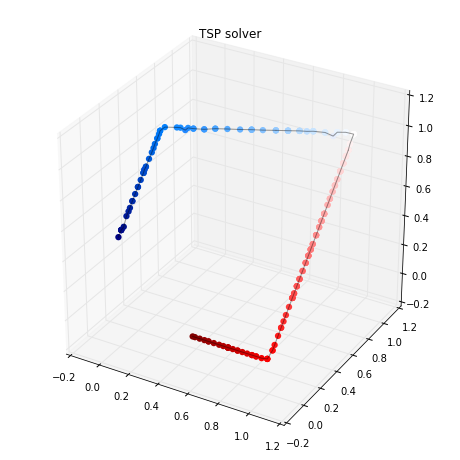

In [271]:
# Set up the figure
fig = plt.figure(figsize=(8, 8))

# Result of TSP solver
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*c.T, c=c, lw=0, s=40, alpha=1)
ax.plot(*c.T, color='k', alpha=0.4)
ax.set_title('TSP solver')

plt.show()

In [272]:
from scipy.spatial import cKDTree
kdtree = cKDTree(c)

In [273]:
dx, ix = kdtree.query(im_)

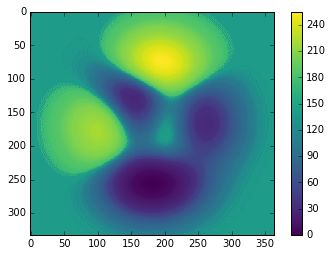

In [274]:
plt.imshow(ix.reshape((h, w)), cmap='viridis')
plt.colorbar()
plt.show()

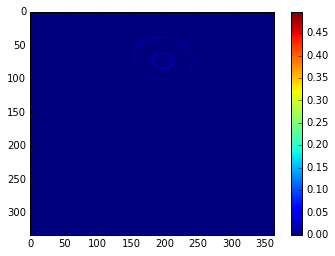

In [275]:
plt.imshow(dx.reshape((h, w)))
plt.colorbar()
plt.show()

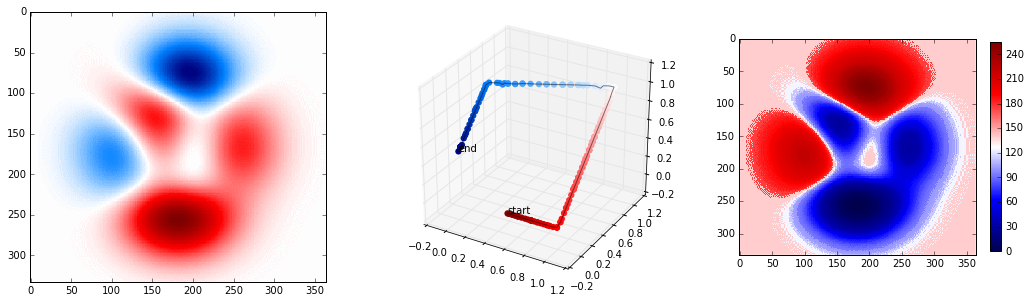

In [280]:
fig = plt.figure(figsize=(18, 5))

ax0 = fig.add_subplot(131)
plt.imshow(im, interpolation='none')

ax1 = fig.add_subplot(132, projection='3d')
ax1.scatter(*c.T, c=c, lw=0, s=40, alpha=1)
ax1.plot(*c.T, color='k', alpha=0.5)
ax1.text(*c[0], 'start')
ax1.text(*c[-1], 'end')

ax2 = fig.add_subplot(133)
plt.imshow(ix.reshape((h, w)), cmap="seismic", interpolation='none')
plt.colorbar(shrink=0.75)

plt.show()

In [277]:
cmaps = [('Perceptually Uniform Sequential',
                            ['viridis', 'inferno', 'plasma', 'magma']),
         ('Sequential',     ['Blues', 'BuGn', 'BuPu',
                             'GnBu', 'Greens', 'Greys', 'Oranges', 'OrRd',
                             'PuBu', 'PuBuGn', 'PuRd', 'Purples', 'RdPu',
                             'Reds', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd']),
         ('Sequential (2)', ['afmhot', 'autumn', 'bone', 'cool',
                             'copper', 'gist_heat', 'gray', 'hot',
                             'pink', 'spring', 'summer', 'winter']),
         ('Diverging',      ['BrBG', 'bwr', 'coolwarm', 'PiYG', 'PRGn', 'PuOr',
                             'RdBu', 'RdGy', 'RdYlBu', 'RdYlGn', 'Spectral',
                             'seismic']),
         ('Qualitative',    ['Accent', 'Dark2', 'Paired', 'Pastel1',
                             'Pastel2', 'Set1', 'Set2', 'Set3']),
         ('Miscellaneous',  ['gist_earth', 'terrain', 'ocean', 'gist_stern',
                             'brg', 'CMRmap', 'cubehelix',
                             'gnuplot', 'gnuplot2', 'gist_ncar',
                             'nipy_spectral', 'jet', 'rainbow',
                             'gist_rainbow', 'hsv', 'flag', 'prism'])]